## Computer Vision (AIRO) Project 4
### Car Plate Recognition and Reconstruction with Deep Learning

### *Baseline 1* : SSD-300 (VGG-16 backbone) detection model + MobileNet V3 Large CNN head and Bi-LSTM recognition model
Model type: 2 stage LPR./
The model takes in a picture containing a license plate, resizes it to 300x300, predicts bounding boxes around the plate./
Takes then the *bbox with the highest confidence score*, crops the original picture with it and sends the crop to the recognizer./
The crop is resized to 224x224 and sent to the MobileNetv3 CNN head, which extracts useful features, which are then pooled along the "height" dimension and sent to a bidirectional LSTM to read the characters and then the output is refined through a FCNN, which then outputs a vector of probabilities for each possible character per detected character on the plate./
Argmaxing these probabilities yield a character sequence, which is the final predicted character sequence for that license plate./

Training losses used: Mixed loss (L1 smooth regression loss for the bbox coordinates + Cross entropy for background/object classification) + CTC loss for character recognition.


### 1) Includes and Utils

In [1]:
import os
import torch
import random
from PIL import Image
import torchvision
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, random_split
import torchvision
from torchvision import transforms
import einops
import torch.nn.functional as F
from torchvision.ops import roi_align
import torchvision.transforms.functional as TF

### 2) Dataset setup

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("binh234/ccpd-preprocess")

print("Path to dataset files:", path)
dataset_path=path+'/CCPD2019/'

Path to dataset files: /home/dalex/.cache/kagglehub/datasets/binh234/ccpd-preprocess/versions/2


Random seed and device setup

In [3]:
# Check if the GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

Using device: cuda


In [4]:
#Run in case GPU memory is full
free_mem = torch.cuda.mem_get_info()[0] / (1024 ** 2)  # Free memory in MB
total_mem = torch.cuda.mem_get_info()[1] / (1024 ** 2) # Total memory in MB
print(f"Free CUDA memory: {free_mem:.2f} MB / {total_mem:.2f} MB")
torch.cuda.empty_cache()

Free CUDA memory: 7100.00 MB / 8191.50 MB


Character list to be used for the recognition task (the output indexes will be associated to each character)

In [5]:
# Suggested CCPD-Preprocess character lists:

provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
       'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

# The "O" means "no character".

#For the predicted characters, instead, a different list has to be used with ALL the characters available (The model doesn't
# make distinctions between the three fields of the plate)

all_characters = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', "O"]
print("Number of characters:", len(all_characters))

province_to_all_idx = [all_characters.index(char) for char in provinces]
alphabet_to_all_idx = [all_characters.index(char) for char in alphabets]
ads_to_all_idx = [all_characters.index(char) for char in ads]

def decode_sequence(indices, all_characters): #The function needed to return the character sequence from the indices
    return ''.join([all_characters[i] for i in indices if i < len(all_characters)])

Number of characters: 68


Dataset class definition

In [6]:
class CCPD_Dataset(Dataset):
    def __init__(self, dataset_path, image_list, transform=None):
        self.transform = transform
        self.dataset_path = dataset_path
        self.image_files = image_list

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path=os.path.join(self.dataset_path, img_name)
        baseimg = Image.open(img_path)
        orig_w, orig_h = baseimg.size
        if self.transform:
            image = self.transform(Image.open(img_path).convert("RGB"))
        else:
            image = Image.open(img_path).convert("RGB")
        fields = img_name.split('-')
        box_str = fields[2]
        leftup, rightbottom = box_str.split('_')
        x1, y1 = map(int, leftup.split(','))
        x2, y2 = map(int, rightbottom.split(','))

        # Target size after transform
        target_w, target_h = 300, 300

        # Scale bbox coordinates
        x1 = x1 * target_w / orig_w
        x2 = x2 * target_w / orig_w
        y1 = y1 * target_h / orig_h
        y2 = y2 * target_h / orig_h

        # Now turn the characters field into a tensor of indices (integers)
        strcharas = fields[4].split('_')
        charaslist = [int(idx) for idx in strcharas]
        provincecharidx = province_to_all_idx[charaslist[0]]
        alphabetcharidx = alphabet_to_all_idx[charaslist[1]]
        adscharidx = []
        for idx in charaslist[2:]:
            adscharidx.append(ads_to_all_idx[idx])
        charaslistdef = [provincecharidx, alphabetcharidx] + adscharidx
        
        boxes = torch.tensor([[x1, y1, x2, y2]], dtype=torch.float32)
        labels = torch.tensor([1], dtype=torch.int64)
        charas = torch.tensor([charaslistdef], dtype=torch.int64)
        target = {
            "boxes": boxes,
            "labels": labels,
            "charas": charas
        }


        return image, target

Dataset split generator (using the suggested splits in the dataset's readme)

In [7]:
def read_split_file(split_file_path):
    with open(split_file_path, 'r') as f:
        return [line.strip() for line in f if line.strip()]

# Paths to split files
split_dir = os.path.join(path, "CCPD2019/splits")  # adjust if needed
train_list = read_split_file(os.path.join(split_dir, "train.txt"))
val_list = read_split_file(os.path.join(split_dir, "val.txt"))
test_list = read_split_file(os.path.join(split_dir, "test.txt"))

From the class, create dataloaders with the dedicated PyTorch function.
(The train dataset here is useless since the training has been done beforehand, but still it's useful to show how it works and what the model has been trained with)

In [8]:
# The augmented version
E2E_transform = transforms.Compose([
    transforms.Resize((340, 340)),
    transforms.RandomRotation(degrees=random.randint(0, 15)),
    transforms.CenterCrop((300, 300)),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# The base version
no_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# This selects one of the two transformations at random for each image.
class RandomTransformSelector:
    def __init__(self, transforms_list):
        self.transforms_list = transforms_list

    def __call__(self, img):
        transform = random.choice(self.transforms_list)
        return transform(img)

random_transform = RandomTransformSelector([E2E_transform, no_transform])
train_dataset = CCPD_Dataset(dataset_path, train_list, transform=random_transform)
val_dataset = CCPD_Dataset(dataset_path, val_list, transform=no_transform)
test_dataset = CCPD_Dataset(dataset_path, test_list, transform=no_transform)

Because the dataset by itself might be too weak and might not help to generalize in various "difficult" situations (very bad lighting, camera alignment, low resolution, pixelization, color channel corruptions...) some extra *augmentations have been used to make this model more robust*. (Note that the augmentations are applied randomly during training)

Here's what a generic training and validation dataset input looks like:

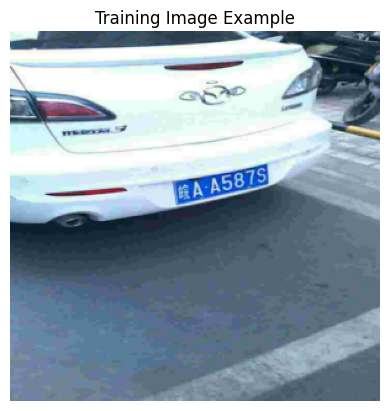

In [9]:
# Train dataset example
image, target = train_dataset[random.randint(0, len(train_dataset)-1)]
image = image * 0.5 + 0.5  # Unnormalize
image = image.clamp(0, 1)  # Clamp to [0, 1] range
plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
plt.axis('off')
plt.title("Training Image Example")
plt.show()

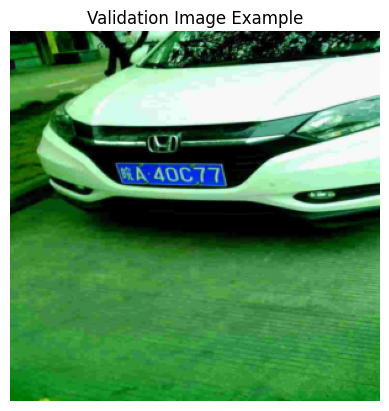

In [10]:
# Train dataset example
image, target = val_dataset[random.randint(0, len(train_dataset)-1)]
image = image * 0.5 + 0.5  # Unnormalize
image = image.clamp(0, 1)  # Clamp to [0, 1] range
plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
plt.axis('off')
plt.title("Validation Image Example")
plt.show()

Naturally, in the test and validation datasets, no augmentations are used

### 3) Model definition

Two pre-trained models are used as the backbones of the License plate recognition model (since this serves only as a baseline for comparison to the tailor-made YOLO-PDLPR model). Bigger, pretrained feature extraction/detection models are always better suited to use along with custom-made network pieces because they are usually very robust and can be appropriately fine-tuned on the desired task with a much smaller dataset than it would be required if we were to build the entire model from the ground up (no Deep Learning model in vision can be properly trained for a specific task and used if absolutely no generalization power is granted to it via pretraining). Pretraining is usually time and resource consuming, but in this way the model itself will be way much lighter, the trianing will take less time, be more effective, and grant an overall stronger and more resilient model.

The two backbones we used are implemented here:

In [11]:
# The detection model
baseline1 = torchvision.models.detection.ssd300_vgg16(progress=True, num_classes=2, weights_backbone='DEFAULT', trainable_backbone_layers=0)
print(baseline1)
print(device)

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [12]:
# The CNN feature extractor for the character recognition task
cnnbackbone = torchvision.models.mobilenet_v3_large(weights='DEFAULT', progress=True)
print(cnnbackbone)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

What is their total size?

In [13]:
def print_model_size_mb(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    size_all_mb = (param_size + buffer_size) / 1024**2
    return size_all_mb

size1 = print_model_size_mb(baseline1)
size2 = print_model_size_mb(cnnbackbone)

print(f"The detection model size: {size1:.2f} MB")
print(f"The CNN backbone model size: {size2:.2f} MB")


The detection model size: 90.58 MB
The CNN backbone model size: 21.01 MB


Completing the recognition model with the RNN layer:

In [14]:
class PlateRecognizer_baseline1(nn.Module):
    def __init__(self, num_classes=68, n_trainable=3):
        super().__init__()
        
        # Freeze all but the last n_trainable layers in the feature extractor
        features = list(cnnbackbone.features.children())
        for layer in features[:-n_trainable]:
            for param in layer.parameters():
                param.requires_grad = False
        cnnbackbone.features = nn.Sequential(*features)
                
        self.cnn = nn.Sequential(
            cnnbackbone.features,
            nn.AdaptiveAvgPool2d((1, None)) # The height needs to be 1 for the CTC to work properly  
        )
        self.rnn = nn.LSTM(960, 256, batch_first=True, bidirectional=True, device=device)
        self.fc = nn.Sequential(
            nn.Linear(512, num_classes*2),
            nn.ReLU(),
            nn.Linear(num_classes*2, num_classes)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.permute(0, 2, 3, 1)
        x = einops.rearrange(x, 'b h w c -> b (h w) c')
        x, _ = self.rnn(x)
        x = self.fc(x)
        return x

Putting it all together:

In [15]:
class PlateDetectAndRecon_baseline1_final(nn.Module):
    def __init__(self, detector, recognizer, crop_size=(224, 224)):
        super().__init__()
        self.detector = detector
        self.recognizer = recognizer
        self.crop_size = crop_size
        self.normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    def forward(self, images, targets=None):
        if self.training and targets is not None:
            # Pass targets to detector for loss computation
            loss_dict = self.detector(images, targets)
            self.detector.eval() #Momentarily, just get the predicted boxes for recognition
            with torch.no_grad():
                outputs = self.detector(images)
            self.detector.train()
        else:
            loss_dict = {}
            outputs = self.detector(images)            
        
        batch_logits = []
        batch_boxes = []
        batch_scores = []
        for i, output in enumerate(outputs):
            boxes = output['boxes']
            scores = output['scores']
            top_k = 5
            
            #Skips with no detections
            if len(scores) == 0: 
                continue 
            
            # ... or if there are less than 5 boxes, pad with zeros
            indices = np.argsort(scores.cpu().numpy())[-top_k:][::-1].copy()  # Make indices contiguous
            indices = torch.from_numpy(indices).to(boxes.device)
            boxes = boxes[indices]
            scores = scores[indices]
            if len(boxes) < top_k:
                pad_boxes = torch.zeros((top_k - len(boxes), 4), dtype=boxes.dtype, device=boxes.device)
                pad_scores = torch.zeros(top_k - len(scores), dtype=scores.dtype, device=scores.device)
                boxes = torch.cat([boxes, pad_boxes], dim=0)
                scores = torch.cat([scores, pad_scores], dim=0)
                
            #----------------Crop formation: Prepare crops to be fed to the recognizer----------------------------
            crops = []
            image = images[i]  # [3, H, W]
            _, H, W = image.shape
            for box in boxes:
                x1, y1, x2, y2 = box.int()
                x1 = max(0, min(x1.item(), W-1))
                x2 = max(0, min(x2.item(), W))
                y1 = max(0, min(y1.item(), H-1))
                y2 = max(0, min(y2.item(), H))
                if x2 <= x1 or y2 <= y1:
                    crop_img = image
                else:
                    crop_img = TF.crop(image, y1, x1, y2-y1, x2-x1)
                crop_img = TF.resize(crop_img, self.crop_size)
                crop_img = self.normalize(crop_img)
                crops.append(crop_img)
            crops = torch.stack(crops).to(image.device)            
            #-----------------------------------------------------------------------------------------------------
                        
            logits = self.recognizer(crops)
            batch_logits.append(logits)
            batch_boxes.append(boxes)
            batch_scores.append(scores)
        # Stack logits for batch: [batch, top_k, seq_len, num_classes]
        batch_logits = torch.stack(batch_logits)
        return batch_logits, batch_boxes, batch_scores, loss_dict

### 4) Training setup

Note that the actual training loop will be commented out to avoid accidental execution.\
Normally both the model weights and optimizer status would need to be loaded. In this case the only runnable line of code will be the one to load the model weights alone for evaluation only. Unless the full model checkpoint file is shipped with this notebook, trying to load the optimizer state as well will not work. If the training loop is uncommented, the training will restart without keeping track of the previous optimizer state and overwrite the previously saved weights.

In [16]:
lr_final = 0.0001

detector = baseline1
recognizer = PlateRecognizer_baseline1()
for name, param in recognizer.named_parameters():
    if torch.isnan(param).any() or torch.isinf(param).any():
        print(f"NaN or Inf in recognizer parameter: {name}")
model = PlateDetectAndRecon_baseline1_final(detector, recognizer)

#Move the model to the device
print("Moving model to device:", device)
detector = detector.to(device)
recognizer = recognizer.to(device)
model = PlateDetectAndRecon_baseline1_final(detector, recognizer).to(device)

#Some papers suggest using SGD with momentum for training the recognizer
optimizer = torch.optim.Adam(list(recognizer.parameters())+list(detector.parameters()), lr=lr_final)

ctc_loss_fn = nn.CTCLoss(blank=67, zero_infinity=True)  # adjust blank index as needed

Moving model to device: cuda


In [17]:
if os.path.exists("fullmodel_checkpoint.pth"):
    checkpoint = torch.load("fullmodel_checkpoint.pth")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print("Loaded model weights WITH the optimizer state.")
elif os.path.exists("SSD_HCNN_weights.pth"):
    model.load_state_dict(torch.load("SSD_HCNN_weights.pth"))
    print("Loaded model weights with no optimizer state. Evaluation ONLY!")
else:
    print("No model weights detected.")

Loaded model weights with no optimizer state. Evaluation ONLY!


Note that during the very first training, the weights were initialized as follows:
- Detector VGG-16 backbone: Default COCO_V1 2017 pretraining weights (link: [github weights recipe](https://github.com/pytorch/vision/tree/main/references/detection#ssd300-vgg16))
- Rest of the SSD layers: Empty
- Recognizer MobileNetV3 large backbone: Default IMAGENET1K_V2 pretraining weights (link: [recipe link](https://github.com/pytorch/vision/tree/main/references/classification#mobilenetv3-large--small))
- LSTM/FCNN linear layers: Kaiming initialization (zero mean)

Training loop:

In [18]:
# The final training loop...
# print("Starting training...")
# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     for batch_idx, (images, targets) in enumerate(train_loader):
#         images = list(img.to(device) for img in images)
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
#         all_gt_sequences = [t['charas'].squeeze(0).to(device) for t in targets]
#         optimizer.zero_grad()
#         
#         # Forward pass
#         outputs = model(images, targets)
#         logits, boxes, scores, loss_dict = outputs
#         
#         # Compute detection loss
#         detloss = sum(loss.to_dense() if loss.is_sparse else loss for loss in loss_dict.values())
#         # The sparsity check is needed because the SSD model may return sparse tensors as losses, but the sum function
#         # expects STRIDED = dense tensors.
# 
#         # Compute recognition loss
#         # Only keep targets for images that produced a detection
#         batch_size_with_detection = logits.shape[0]
#         gt_sequences = all_gt_sequences[:batch_size_with_detection]
#         gt_lengths = torch.tensor([seq.size(0) for seq in gt_sequences], dtype=torch.long)
#         gt_targets = torch.cat(gt_sequences)
#         gt_lengths = gt_lengths.to(device)
#         gt_targets = gt_targets.to(device)
#         
#         # logits: [batch, top_k, seq_len, num_classes]
#         # For CTC: input should be [seq_len, batch, num_classes]
#         logits = logits[:, 0, :, :] # Use only the top-1 box per image: [batch, seq_len, num_classes]
#         blank_penalty = 1.0  # You can tune this value (start with 1.0)
#         logits[ : ,-1] -= blank_penalty
#         logits = logits.permute(1, 0, 2)  # [seq_len, batch, num_classes]
#         # print(logits)
#         probs = F.log_softmax(logits, dim=2)
#         input_lengths = torch.full(size=(logits.size(1),), fill_value=logits.size(0), dtype=torch.long)              
#         recloss = ctc_loss_fn(probs, gt_targets, input_lengths, gt_lengths)        
#         
#         total_loss = detloss + recloss
#         total_loss.backward()
#         optimizer.step()
#         running_loss += total_loss.item()
#         if batch_idx % 500 == 0:
#             print(f"Epoch {epoch+1}, Batch {batch_idx}/{len(train_loader)}, Loss: {total_loss.item():.4f}")
#             #Since the optimizer state is too large, I'm gonna save a full checkpoint with everything at every epoch
#             #AND a copy of the model weights only for evaluation.
#             torch.save({
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#             }, "/home/dalex/AIRO_2024-2025/Computer_Vision/CVProject2025/CVProject2025/fullmodel_checkpoint.pth") 
#             torch.save(model.state_dict(), "/home/dalex/AIRO_2024-2025/Computer_Vision/CVProject2025/CVProject2025/SSD_HCNN_weights.pth")
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
#     
#     #Since the optimizer state is too large, I'm gonna save a full checkpoint with everything at every epoch
#     #AND a copy of the model weights only for evaluation.
#     torch.save({
#         'model_state_dict': model.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#     }, "/home/dalex/AIRO_2024-2025/Computer_Vision/CVProject2025/CVProject2025/fullmodel_checkpoint.pth")
#     
#     torch.save(model.state_dict(), "/home/dalex/AIRO_2024-2025/Computer_Vision/CVProject2025/CVProject2025/SSD_HCNN_weights.pth")

### 5) Validation setup

To validate the model, as how it's shown in [the paper suggested by the professor](https://www.mdpi.com/1424-8220/24/9/2791), two metrics will be used for the detection and the recognition part:\
- Detection: IoU best predicted bounding box vs Ground-Truth (GT) bounding box, and percentile accuracy (%ACC) of predicted boxes (correct prediction if IoU > 0.6. Added extra leeway since in the paper the requisite is 0.7 for detection and 0.6 for recognition. Used lower lower bound)
- Recognition: %ACC over character readings (if IoU > 0.6 and NO MISTAKES committed while reading the plate = Correct prediction.)

Here, a single random prediction on the validation dataset to show how it works:

In [19]:
# Function needed to show the predicted bounding boxes and the ground truth box
def show_bounding_box_with_gt(image, boxes, scores=None, top_k=None, gt_box=None):
    image = image.permute(1, 2, 0).cpu().numpy()
    image = (image * 0.5 + 0.5).clip(0, 1)
    plt.imshow(image)
    
    cmap = plt.colormaps.get_cmap('plasma')
    
    if scores is not None:
        if top_k is not None:
            indices = np.argsort(scores)[-top_k:][::-1]
            boxes = boxes[indices]
            scores = scores[indices]
        norm_scores = (scores - scores.min()) / (scores.max() - scores.min() + 1e-6)
        colors = cmap(norm_scores)
        
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box
        color = colors[i][:3] if scores is not None else 'red'
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color=color, linewidth=2))
        plt.text(x1, y1 - 5, str(i + 1), color='white', fontsize=12, weight='bold', 
                 bbox=dict(facecolor=color, edgecolor='none', pad=1, alpha=0.7))
    
    # Draw ground truth box in green
    if gt_box is not None:
        x1, y1, x2, y2 = gt_box
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='lime', linewidth=2, linestyle='--'))
        plt.text(x1, y1 - 15, "GT", color='lime', fontsize=12, weight='bold', 
                 bbox=dict(facecolor='black', edgecolor='none', pad=1, alpha=0.7))
    
    if scores is not None and len(scores) > 0:
        norm = mpl.colors.Normalize(vmin=scores.min(), vmax=scores.max())
        sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=plt.gca(), fraction=0.046, pad=0.04)
        cbar.set_label('Confidence Score') 
    
    plt.suptitle(f'Predicted Bounding Boxes (Showing best {len(boxes)} boxes)')   
    plt.axis('off')
    plt.show()

# ...and the IoU function    
def IoU(pred_bbox, target_bbox):
    predbbox_length = pred_bbox[0][2] - pred_bbox[0][0]
    predbbox_height = pred_bbox[0][3] - pred_bbox[0][1]
    targetbbox_length = target_bbox[0][2] - target_bbox[0][0]
    targetbbox_height = target_bbox[0][3] - target_bbox[0][1]

    intersectionarea = torch.max(torch.tensor(0), torch.min(pred_bbox[0][2], target_bbox[0][2]) - torch.max(pred_bbox[0][0], target_bbox[0][0])) * torch.max(torch.tensor(0), torch.min(pred_bbox[0][3], target_bbox[0][3]) - torch.max(pred_bbox[0][1], target_bbox[0][1]))
    unionarea = predbbox_length * predbbox_height + targetbbox_length * targetbbox_height - intersectionarea
    iou = intersectionarea / unionarea
    return iou

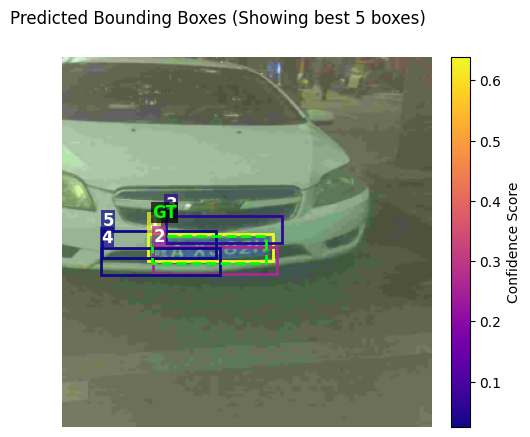

Correct sequence: 皖AX382H
Predicted Characters: 皖AX382H
IoU between predicted and ground truth box: 0.8064
Prediction is correct!


In [21]:
model.eval()
with torch.no_grad():
    # Get a random image from the training set
    image, target = val_dataset[random.randint(0, len(train_dataset)-1)]
    image = image.to(device)
    # Call the full model (no need to call backbone or recognizer directly)
    logits, boxes, scores, _ = model([image])
    indices = target["charas"].squeeze(0).tolist()  # shape [7]
    decoded = decode_sequence(indices, all_characters)
    logits = logits[:, 0, :, :]  # [batch, seq_len, num_classes], batch=1
    pred_indices = logits.argmax(dim=2)[0].cpu().tolist()
    pred_str = decode_sequence(pred_indices, all_characters)
    bbox = boxes[0].cpu().numpy()
    confscores = scores[0].cpu().numpy()

    # Extract ground truth box from the target
    gt_box = target['boxes'][0].cpu().numpy()  # shape: (4,)

    # Use the new function
    show_bounding_box_with_gt(image.cpu(), bbox, confscores, top_k=5, gt_box=gt_box)

    print(f"Correct sequence: {decoded}")
    print(f"Predicted Characters: {pred_str}")
    plt.show()
    
    #Now get best bbox to compute IoU
    best_idx = confscores.argmax()
    best_box = bbox[best_idx]
    best_box = torch.tensor(best_box).unsqueeze(0)  # Convert to tensor and add batch dimension
    target_box = target['boxes'][0].unsqueeze(0)  # Convert to tensor and add batch dimension
    iou = IoU(best_box, target_box)
    print(f"IoU between predicted and ground truth box: {iou.item():.4f}")
    if iou > 0.6 and pred_str == decoded:
        print("Prediction is correct!")
    else:
        print("Prediction is incorrect.")